In [10]:
import gym
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
class Policy(nn.Module):
  def __init__(self,state_size:int=4,action_size:int=2,hidden_dim:int=64):
    super().__init__()
    self.fc1 = nn.Linear(state_size,hidden_dim)
    self.fc2 = nn.Linear(hidden_dim,action_size)

  def forward(self,state):
    outs = self.fc1(state)
    outs = F.relu(outs)
    logits = self.fc2(outs)
    return logits



In [38]:
class Agent:
  def __init__(self,
               policy,
               opt,
               env_name='CartPole-v1',
               gamma = 0.99,
               lr=0.001):
    self.policy = policy
    self.opt = opt
    self.env = gym.make(env_name)
    self.gamma = gamma
    self.lr = lr


  # pick up action with above distribution policy
  def sample(self,s):
    with torch.no_grad():
      # --> size(1,4)
      s_batch = np.expand_dims(s,axis=0)
      s_batch = torch.tensor(s_batch,dtype=torch.float).to(device)

      # get logits from state
      # --> size (1,2)
      logits = self.policy(s_batch)

      # --> size(2)
      logits = logits.squeeze(dim=0)

      # from logits to probabilities
      probs = F.softmax(logits,dim=-1)

      # pick up action's sample
      action = torch.multinomial(probs,num_samples=1)
      return action.tolist()[0]

  def train(self):

    self.reward_records = []
    for i in range(1000):

      # Run episode till done
      done = False
      states = []
      actions = []
      rewards = []
      s = self.env.reset()
      while not done:
        states.append(s.tolist())
        a = self.sample(s)
        s,r,term,trunc ,= self.env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

      # Get cumulative rewards
      cum_rewards = np.zeros_like(rewards)
      reward_len = len(rewards)
      for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*self.gamma if j+1 < reward_len else 0)

      # Train (optimzer parameters)
      states = torch.tensor(states, dtype=torch.float).to(device)
      actions = torch.tensor(actions, dtype=torch.int64).to(device)
      cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
      self.opt.zero_grad()
      logits = self.policy(states)

      # Calculate negative log probability (-log P) as loss.
      # Cross-entropy loss is -log P in categorical distribution. (see above)
      log_probs = -F.cross_entropy(logits, actions,reduction='none')
      loss = -log_probs * cum_rewards
      loss.sum().backward()
      self.opt.step()
      # Record total rewards in episode (max 500)
      print("Run episode{} with rewards {}".format(i, sum(rewards)))
      self.reward_records.append(sum(rewards))
    print('\nDone')
    self.env.close()

  def plot(self):
    import matplotlib.pyplot as plt
    # Generate recent 50 interval average
    average_reward = []
    for idx in range(len(self.reward_records)):
      avg_list = np.empty(shape=(1,), dtype=int)
      if idx < 50:
          avg_list = self.reward_records[:idx+1]
      else:
          avg_list = self.reward_records[idx-49:idx+1]
      average_reward.append(np.average(avg_list))
      # Plot
      plt.plot(self.reward_records)
      plt.plot(average_reward)






Run episode0 with rewards 15.0
Run episode1 with rewards 20.0
Run episode2 with rewards 12.0
Run episode3 with rewards 75.0
Run episode4 with rewards 17.0
Run episode5 with rewards 22.0
Run episode6 with rewards 31.0
Run episode7 with rewards 18.0
Run episode8 with rewards 9.0
Run episode9 with rewards 19.0
Run episode10 with rewards 22.0
Run episode11 with rewards 19.0
Run episode12 with rewards 44.0
Run episode13 with rewards 20.0
Run episode14 with rewards 13.0
Run episode15 with rewards 13.0
Run episode16 with rewards 13.0
Run episode17 with rewards 17.0
Run episode18 with rewards 12.0
Run episode19 with rewards 15.0
Run episode20 with rewards 25.0
Run episode21 with rewards 35.0
Run episode22 with rewards 25.0
Run episode23 with rewards 15.0
Run episode24 with rewards 37.0
Run episode25 with rewards 32.0
Run episode26 with rewards 19.0
Run episode27 with rewards 30.0
Run episode28 with rewards 14.0
Run episode29 with rewards 15.0
Run episode30 with rewards 22.0
Run episode31 with 

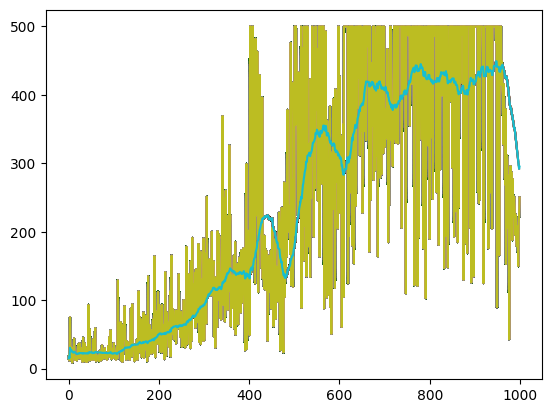

In [39]:
policy = Policy().to(device)
opt = torch.optim.AdamW(policy.parameters(), lr=0.001)
agent = Agent(policy,opt)
agent.train()
agent.plot()